In [9]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set random seed for reproducibility
RANDOM_STATE = 42

In [2]:
# Load the dataset
df = pd.read_csv('Fashion_Retail_Sales.csv')

# Preview the dataset
print("Initial shape:", df.shape)
display(df.head())
display(df.info())

Initial shape: (3400, 6)


,Customer Reference ID,Item Purchased,Purchase Amount (USD),Date Purchase,Review Rating,Payment Method
0,4018,Handbag,4619.0,05-02-2023,NaN,Credit Card
1,4115,Tunic,2456.0,11-07-2023,2.0,Credit Card
2,4019,Tank Top,2102.0,23-03-2023,4.1,Cash
3,4097,Leggings,3126.0,15-03-2023,3.2,Cash
4,3997,Wallet,3003.0,27-11-2022,4.7,Cash


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Customer Reference ID  3400 non-null   int64  
 1   Item Purchased         3400 non-null   object 
 2   Purchase Amount (USD)  2750 non-null   float64
 3   Date Purchase          3400 non-null   object 
 4   Review Rating          3076 non-null   float64
 5   Payment Method         3400 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 159.5+ KB


None

In [4]:
# Drop rows with missing target values
df = df.dropna(subset=['Purchase Amount (USD)'])

# Fill remaining missing values with 0
df = df.fillna(0)

# Sort columns alphabetically (optional)
df = df.reindex(sorted(df.columns), axis=1)

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, drop_first=True)

# Move target column to end (optional for clarity)
cols = [col for col in df_encoded.columns if col != 'Purchase Amount (USD)'] + ['Purchase Amount (USD)']
df_encoded = df_encoded[cols]

# Split into features and target
X = df_encoded.drop('Purchase Amount (USD)', axis=1)
y = df_encoded['Purchase Amount (USD)']

print("Encoded dataset shape:", df_encoded.shape)

Encoded dataset shape: (2750, 417)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=RANDOM_STATE
)

print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")

Training features shape: (2337, 416)
Test features shape: (413, 416)


In [6]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

In [11]:
def evaluate_model_cv(model, X, y, model_name, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)

    mae = -1 * cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=kf).mean()
    rmse = np.sqrt(-1 * cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf).mean())
    r2 = cross_val_score(model, X, y, scoring='r2', cv=kf).mean()

    print(f"\n{model_name} Cross-Validated Performance (cv={cv}):")
    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.2f}")

    return {'Model': model_name, 'MAE': mae, 'RMSE': rmse, 'R2': r2}


Linear Regression Cross-Validated Performance (cv=5):
MAE:  163.91
RMSE: 461.63
R²:   -0.25

Random Forest Cross-Validated Performance (cv=5):
MAE:  123.93
RMSE: 450.58
R²:   -0.18


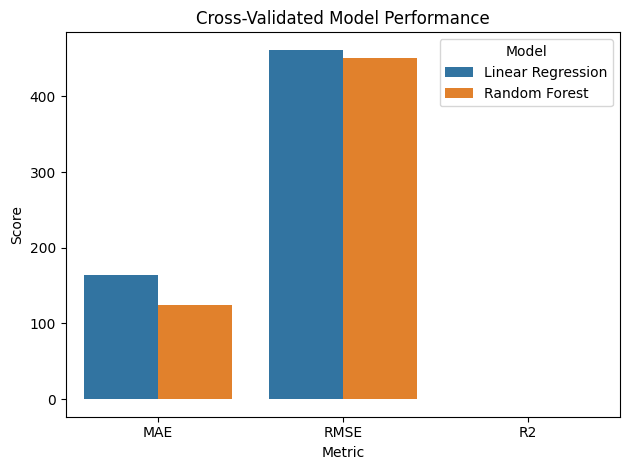

In [13]:
# Initialize models
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)

# Compare with cross-validation
results = []
results.append(evaluate_model_cv(lr, X, y, "Linear Regression"))
results.append(evaluate_model_cv(rf, X, y, "Random Forest"))

# Plot comparison
results_df = pd.DataFrame(results)
sns.barplot(data=results_df.melt(id_vars='Model'), x='variable', y='value', hue='Model')
plt.title("Cross-Validated Model Performance")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.tight_layout()
plt.show()

In [15]:
import joblib

# Final model on all data
final_model = RandomForestRegressor(n_estimators=100, random_state=42)
final_model.fit(X, y)

# Save to disk
joblib.dump(final_model, "model.pkl")
joblib.dump(X.columns.tolist(), "model_columns.pkl")

['model_columns.pkl']